# Stage 10b — Time Series / Classification (ASML)
Lag & rolling features → time-aware split → pipeline → metrics → interpretation.


Imports, paths, helpers

In [1]:
from __future__ import annotations
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from dotenv import load_dotenv

# Resolve project root when running from project/notebooks
project_root = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd().resolve()
sys.path.append(str(project_root / "src"))

load_dotenv(project_root / ".env")
from storage import env_paths, read_df, write_df
RAW_DIR, PROC_DIR = env_paths(project_root)

MODEL_DIR = PROC_DIR / "modeling"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
def stamp(): return datetime.now().strftime("%Y%m%d-%H%M")


Load dataset

In [2]:
feat_candidates  = sorted(PROC_DIR.glob("asml_features_*.parquet")) + sorted(PROC_DIR.glob("asml_features_*.csv"))
clean_candidates = sorted(PROC_DIR.glob("asml_cleaned_*.parquet")) + sorted(PROC_DIR.glob("asml_cleaned_*.csv"))
raw_candidates   = sorted(RAW_DIR.glob("api_*ASML_*.csv"))

if feat_candidates:
    path = feat_candidates[-1]
    print("Using FEATURES:", path.name)
    df = read_df(path, parse_dates=["date"])
elif clean_candidates:
    path = clean_candidates[-1]
    print("Using CLEANED:", path.name)
    df = read_df(path, parse_dates=["date"])
else:
    path = raw_candidates[-1]
    print("Using RAW:", path.name)
    df = read_df(path, parse_dates=["date"])

df = df.sort_values("date").reset_index(drop=True)
price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"


Using FEATURES: asml_features_20250821-1006.csv


Engineer ≥2 new lag/rolling features (no leakage)

In [3]:
# Ensure base return exists
if "ret" not in df.columns:
    df["ret"] = df[price_col].pct_change()

# NEW features for Stage 10b (choose at least two)
df["ret_lag5"]      = df["ret"].shift(5)               # lag_k
df["ret_mean_5"]    = df["ret"].rolling(5).mean()      # rolling_mean
df["ret_std_21"]    = df["ret"].rolling(21).std()      # rolling_std
# Optional: rolling z-score of returns
df["ret_z_21"]      = (df["ret"] - df["ret"].rolling(21).mean()) / df["ret"].rolling(21).std()

# Targets (regression & classification)
df["y_next_ret"] = df[price_col].pct_change().shift(-1)                 # forecast next-step return
df["y_next_up"]  = (df["y_next_ret"] > 0).astype("Int64")               # classify next-day direction

# Drop rows with NaNs introduced by rolling/shift
df = df.dropna(subset=["ret","ret_lag5","ret_mean_5","ret_std_21","y_next_ret","y_next_up"]).reset_index(drop=True)
df[["date","ret","ret_lag5","ret_mean_5","ret_std_21","ret_z_21","y_next_ret","y_next_up"]].head()


,date,ret,ret_lag5,ret_mean_5,ret_std_21,ret_z_21,y_next_ret,y_next_up
0,2020-09-16,-0.021256,0.034605,0.001784,0.024997,-0.779498,0.012032,1
1,2020-09-17,0.012032,-0.006595,0.005509,0.025173,0.519069,-0.001091,0
2,2020-09-18,-0.001091,0.006247,0.004042,0.025147,-0.011590,-0.010154,0
3,2020-09-21,-0.010154,0.024246,-0.002838,0.025191,-0.366141,0.005571,1
4,2020-09-22,0.005571,0.006278,-0.002980,0.025230,0.246922,-0.019417,0


Define common feature set & time-aware split (80/20)

In [4]:
# Pick features that exist (add more if present from Stage 09)
candidate_X = [
    "ret","ret_lag1","ret_lag5","ret_mean_5","ret_std_21","ret_z_21",
    "mom_5","mom_21","rsi_14","vol_21","range_21",
    "is_month_end","is_quarter_end"
] + [c for c in df.columns if c.startswith("dow_")]

X_cols = [c for c in candidate_X if c in df.columns]
X = df[X_cols].copy()
dates = df["date"].copy()

# Time-aware split
split = int(len(X) * 0.80)
X_train, X_test = X.iloc[:split, :], X.iloc[split:, :]
dates_train, dates_test = dates.iloc[:split], dates.iloc[split:]


TRACK A — Time-Series Regression (forecast next-day return)

In [5]:
y_train_reg = df["y_next_ret"].iloc[:split]
y_test_reg  = df["y_next_ret"].iloc[split:]

reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

reg_pipe.fit(X_train, y_train_reg)
yhat_tr = reg_pipe.predict(X_train)
yhat_te = reg_pipe.predict(X_test)

reg_metrics = {
    "r2_train": r2_score(y_train_reg, yhat_tr),
    "r2_test":  r2_score(y_test_reg,  yhat_te),
    "mae_train": mean_absolute_error(y_train_reg, yhat_tr),
    "mae_test":  mean_absolute_error(y_test_reg,  yhat_te),
    "rmse_train": float(np.sqrt(mean_squared_error(y_train_reg, yhat_tr))),
    "rmse_test":  float(np.sqrt(mean_squared_error(y_test_reg,  yhat_te))),
}
reg_metrics


{'r2_train': 0.011076287547023278,
 'r2_test': -0.008516863901569138,
 'mae_train': 0.019325819941723353,
 'mae_test': 0.01821233723575786,
 'rmse_train': 0.025631525136161997,
 'rmse_test': 0.027410920169773728}

Plot predicted vs truth (test set) 

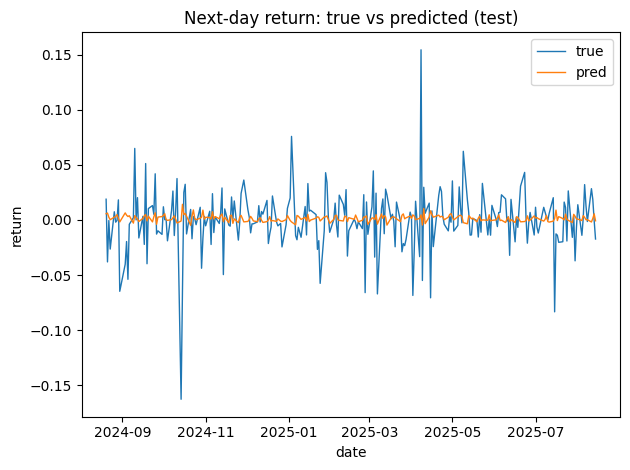

WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/modeling/ts_reg_pred_vs_true_20250823-1332.png')

In [6]:
plt.figure()
plt.plot(dates_test, y_test_reg.values, label="true", linewidth=1)
plt.plot(dates_test, yhat_te, label="pred", linewidth=1)
plt.title("Next-day return: true vs predicted (test)")
plt.xlabel("date"); plt.ylabel("return")
plt.legend(); plt.tight_layout()

plot_path = MODEL_DIR / f"ts_reg_pred_vs_true_{stamp()}.png"
plt.savefig(plot_path, dpi=150)
plt.show()

# Save metrics
import pandas as pd
pd.DataFrame(reg_metrics, index=["metrics"]).T.to_csv(MODEL_DIR / f"ts_reg_metrics_{stamp()}.csv")
plot_path


TRACK B — Classification (predict next-day up/down)

In [7]:
y_train_clf = df["y_next_up"].iloc[:split].astype(int)
y_test_clf  = df["y_next_up"].iloc[split:].astype(int)

clf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=200, class_weight="balanced"))  # balanced for mild imbalance
])

clf_pipe.fit(X_train, y_train_clf)
yhat_prob = clf_pipe.predict_proba(X_test)[:,1]
yhat_cls  = (yhat_prob >= 0.5).astype(int)


In [8]:
acc = accuracy_score(y_test_clf, yhat_cls)
prec = precision_score(y_test_clf, yhat_cls, zero_division=0)
rec = recall_score(y_test_clf, yhat_cls, zero_division=0)
f1  = f1_score(y_test_clf, yhat_cls, zero_division=0)
cm  = confusion_matrix(y_test_clf, yhat_cls)

clf_metrics = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1}
clf_metrics


{'accuracy': 0.4777327935222672,
 'precision': 0.4897959183673469,
 'recall': 0.3779527559055118,
 'f1': 0.4266666666666667}

Plot confusion matrix

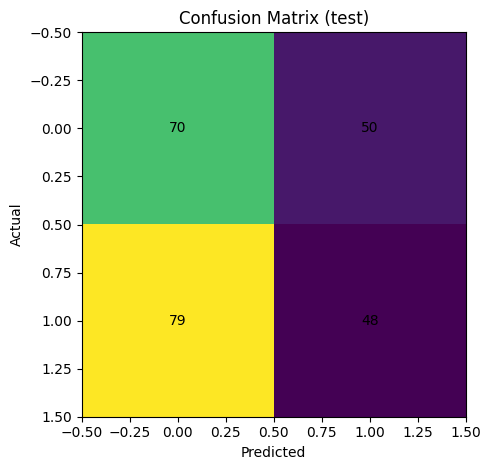

WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/modeling/classification_confusion_20250823-1334.png')

In [9]:
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (test)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j),v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()

cm_path = MODEL_DIR / f"classification_confusion_{stamp()}.png"
plt.savefig(cm_path, dpi=150)
plt.show()

# Save metrics
pd.DataFrame(clf_metrics, index=["metrics"]).T.to_csv(MODEL_DIR / f"classification_metrics_{stamp()}.csv")
cm_path
